## Install modules

In [16]:
# !pip install -qU diffusers opencv-contrib-python transformers accelerate
# !pip install -qU controlnet_aux

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 0.12.1+cu116 requires torch==1.12.1, but you have torch 2.0.0 which is incompatible.
torchvision 0.13.1+cu116 requires torch==1.12.1, but you have torch 2.0.0 which is incompatible.

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python3.9 -m pip install --upgrade pip


## Annotators

In [2]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# Let's load the popular vermeer image
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

In [3]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

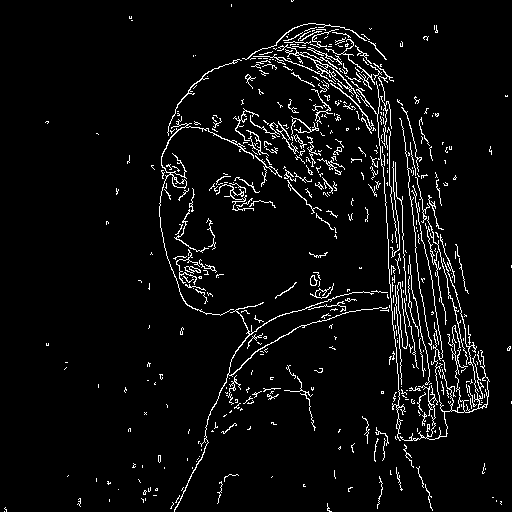

In [4]:
canny_image

## ControlNet

In [5]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [6]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# this command loads the individual model components on GPU on-demand.
pipe.enable_model_cpu_offload()

In [7]:
generator = torch.manual_seed(0)

out_image = pipe(
    "disco dancer with colorful lights", num_inference_steps=20, generator=generator, image=canny_image
).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

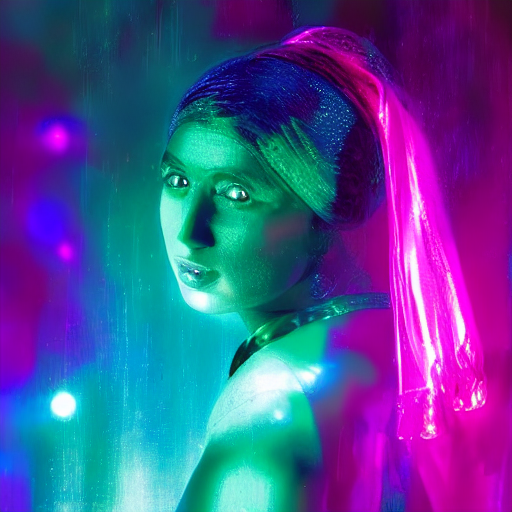

In [8]:
out_image

## Multi ControlNet

In [9]:
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

canny_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/landscape.png"
)
canny_image = np.array(canny_image)

low_threshold = 100
high_threshold = 200

canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)

# zero out middle columns of image where pose will be overlayed
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

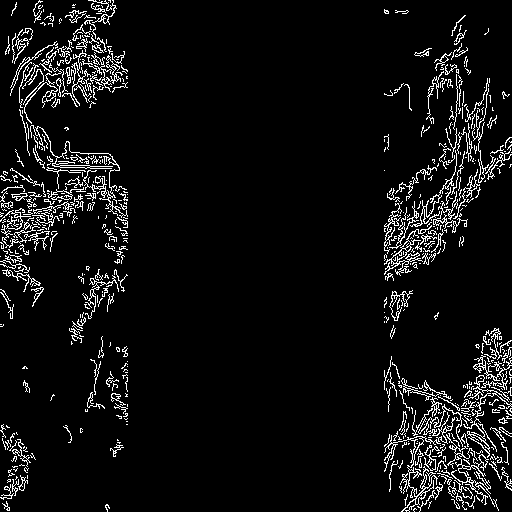

In [10]:
canny_image

In [13]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image = openpose(openpose_image)

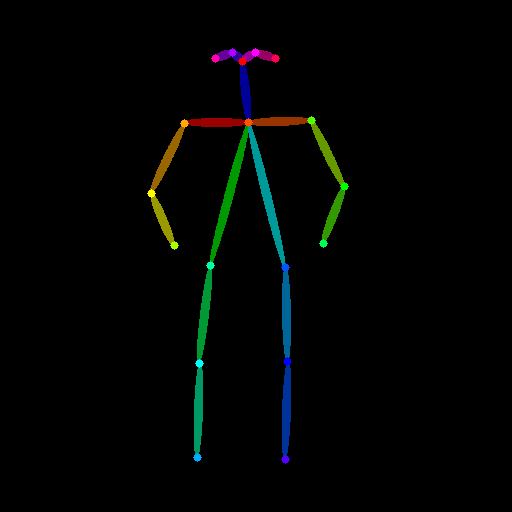

In [14]:
openpose_image

In [17]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

controlnet = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),
]

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

prompt = "a giant standing in a fantasy landscape, best quality"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"

generator = torch.Generator(device="cpu").manual_seed(1)

images = [openpose_image, canny_image]

image = pipe(
    prompt,
    images,
    num_inference_steps=20,
    generator=generator,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=[1.0, 0.8],
).images[0]

# image.save("./multi_controlnet_output.png")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

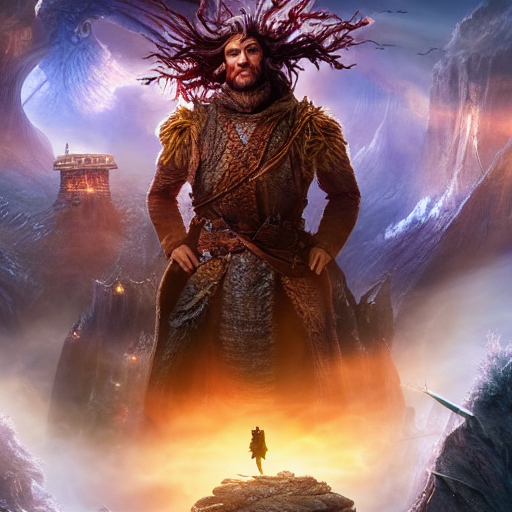

In [18]:
image